In [397]:
import torch
import dill
import matplotlib.pyplot as plt
from diffusion_policy.policy.diffusion_unet_timm_policy import DiffusionUnetTimmPolicy
from diffusion_policy.model.vision.timm_obs_encoder import TimmObsEncoder
import hydra
from PIL import Image
import numpy as np
import math
import cv2
from ipywidgets import interact, IntSlider

In [2]:
ckpt_path = "/Users/michaellutz/Documents/umi_checkpoints/cup_wild_vit_l_1img.ckpt.2"
payload = torch.load(open(ckpt_path, 'rb'), map_location='cpu', pickle_module=dill)

In [326]:
policy = hydra.utils.instantiate(payload['cfg'].policy)
horizon = payload['cfg'].task.shape_meta.obs.camera0_rgb.horizon

vit will use the CLS token. feature_aggregation (attention_pool_2d) is ignored!


rgb keys:          ['camera0_rgb']
low_dim_keys keys: ['robot0_eef_pos', 'robot0_eef_rot_axis_angle', 'robot0_eef_rot_axis_angle_wrt_start', 'robot0_gripper_width']


In [327]:
obs_encoder = policy.obs_encoder
vit = obs_encoder.key_model_map['camera0_rgb']

In [104]:
def process_img(img):
    img = img.copy()
    img = img.transpose(0, 3, 1, 2)
    img = torch.from_numpy(img)
    img = obs_encoder.key_transform_map['camera0_rgb'](img)
    img = img.to(torch.float32)
    img = img / 255.0
    return img

In [141]:
# Getting the Image
img = Image.open('/Users/michaellutz/Documents/development/universal_manipulation_interface/ep_0_img_0.png')
img = np.array(img)
img = img[np.newaxis, ...]
img_processed = process_img(img)

# Understanding the Model

In [320]:
vit

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (

# Getting the Entire Model to Run

In [324]:
policy.forward(img_processed)

RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'str'>.

# Common Functions for Interp

In [106]:
import matplotlib.pyplot as plt
from captum.attr import visualization

In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [216]:
def show_image_relevance(image_relevance, image, orig_image):
    orig_image = orig_image[0]
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    _, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image)
    axs[0].axis('off')

    dim = int(image_relevance.shape[-1] ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis)
    axs[1].axis('off')
    plt.show()

In [349]:
def get_attention_map(qkv, d_model=1024, num_heads=16):
    assert qkv.shape[-1] == d_model * 3
    head_dim = d_model // num_heads

    q = qkv[:, :, :d_model]
    k = qkv[:, :, d_model:2*d_model]

    q = q.view(q.shape[0], q.shape[1], num_heads, head_dim)
    k = k.view(k.shape[0], k.shape[1], num_heads, head_dim)

    q = q.permute(0, 2, 1, 3)
    k = k.permute(0, 2, 1, 3)

    attn_map = torch.softmax(torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(head_dim), dim=-1)
    return attn_map

# Raw Attention (last)
Taking the last layer attention as the baseline

In [350]:
# Initializing hook on the last layer

def hook_fn_factory(qkv_vectors):
    def hook_fn(_module, model_in, model_out):
        qkv_vectors.append(model_out)
    return hook_fn


# TODO: complete when figured out...
def get_heatmap_raw_attention_last(vit):
    vit.zero_grad()
    qkv_vectors = [] # Including list for easy pointer access... really will only be size 1

    # Setting the hooks
    hook_fn = hook_fn_factory(qkv_vectors)
    last_qkv = vit.blocks[-1].attn.qkv
    hook = last_qkv.register_forward_hook(hook_fn)

    # Running the forward pass
    vit.forward(img_processed)
    hook.remove()

    # Getting the attention map
    A = get_attention_map(qkv_vectors[0], d_model=1024, num_heads=16)
    A = A.mean(dim=1)

    # Cleaning up the attention map into a heatmap...
    R = A[:, 0, 1:].detach()
    
    return R

In [351]:
R = get_heatmap_raw_attention_last(vit)

In [352]:
R.shape

torch.Size([1, 256])

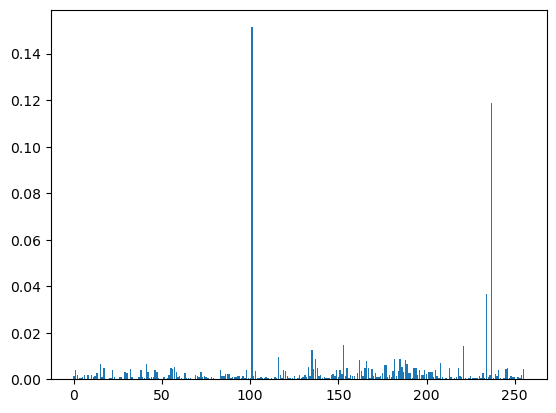

In [353]:
plt.bar(np.arange(0, 256), R[0])
plt.show()

In [354]:
image_relevance = R.reshape(1, 1, 16, 16)
torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear').shape

torch.Size([1, 1, 224, 224])

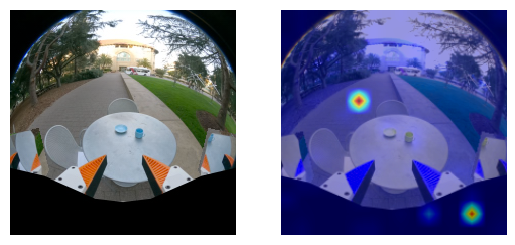

In [355]:
show_image_relevance(R, img_processed, img)

I am very unsure regarding whether this is the unexpected result. Not sure if it's an error with processing the correct mask or if it's just the fact that attention gets processed elsewhere...

Worth investigating...

# Raw Attention (one layer at a time)

In [398]:
# Initializing hook on the first layer

def hook_fn_factory(qkv_vectors):
    def hook_fn(_module, model_in, model_out):
        qkv_vectors.append(model_out)
    return hook_fn

# TODO: complete when figured out...
def get_heatmap_raw_attention_block(vit, block_index):
    vit.zero_grad()
    qkv_vectors = []  # Including list for easy pointer access... really will only be size 1

    # Setting the hooks
    hook_fn = hook_fn_factory(qkv_vectors)
    block_qkv = vit.blocks[block_index].attn.qkv
    hook = block_qkv.register_forward_hook(hook_fn)

    # Running the forward pass
    vit.forward(img_processed)
    hook.remove()

    # Getting the attention map
    A = get_attention_map(qkv_vectors[0])
    A = A.mean(dim=1)

    # Cleaning up the attention map into a heatmap...
    R = A[:, 0, 1:].detach()
    
    return R

In [402]:
# Create a slider to select the block index
interact(lambda block_index: show_image_relevance(get_heatmap_raw_attention_block(vit, block_index), img_processed, img),
         block_index=IntSlider(min=0, max=24, step=1, value=9))

interactive(children=(IntSlider(value=9, description='block_index', max=24), Output()), _dom_classes=('widget-…

<function __main__.<lambda>(block_index)>

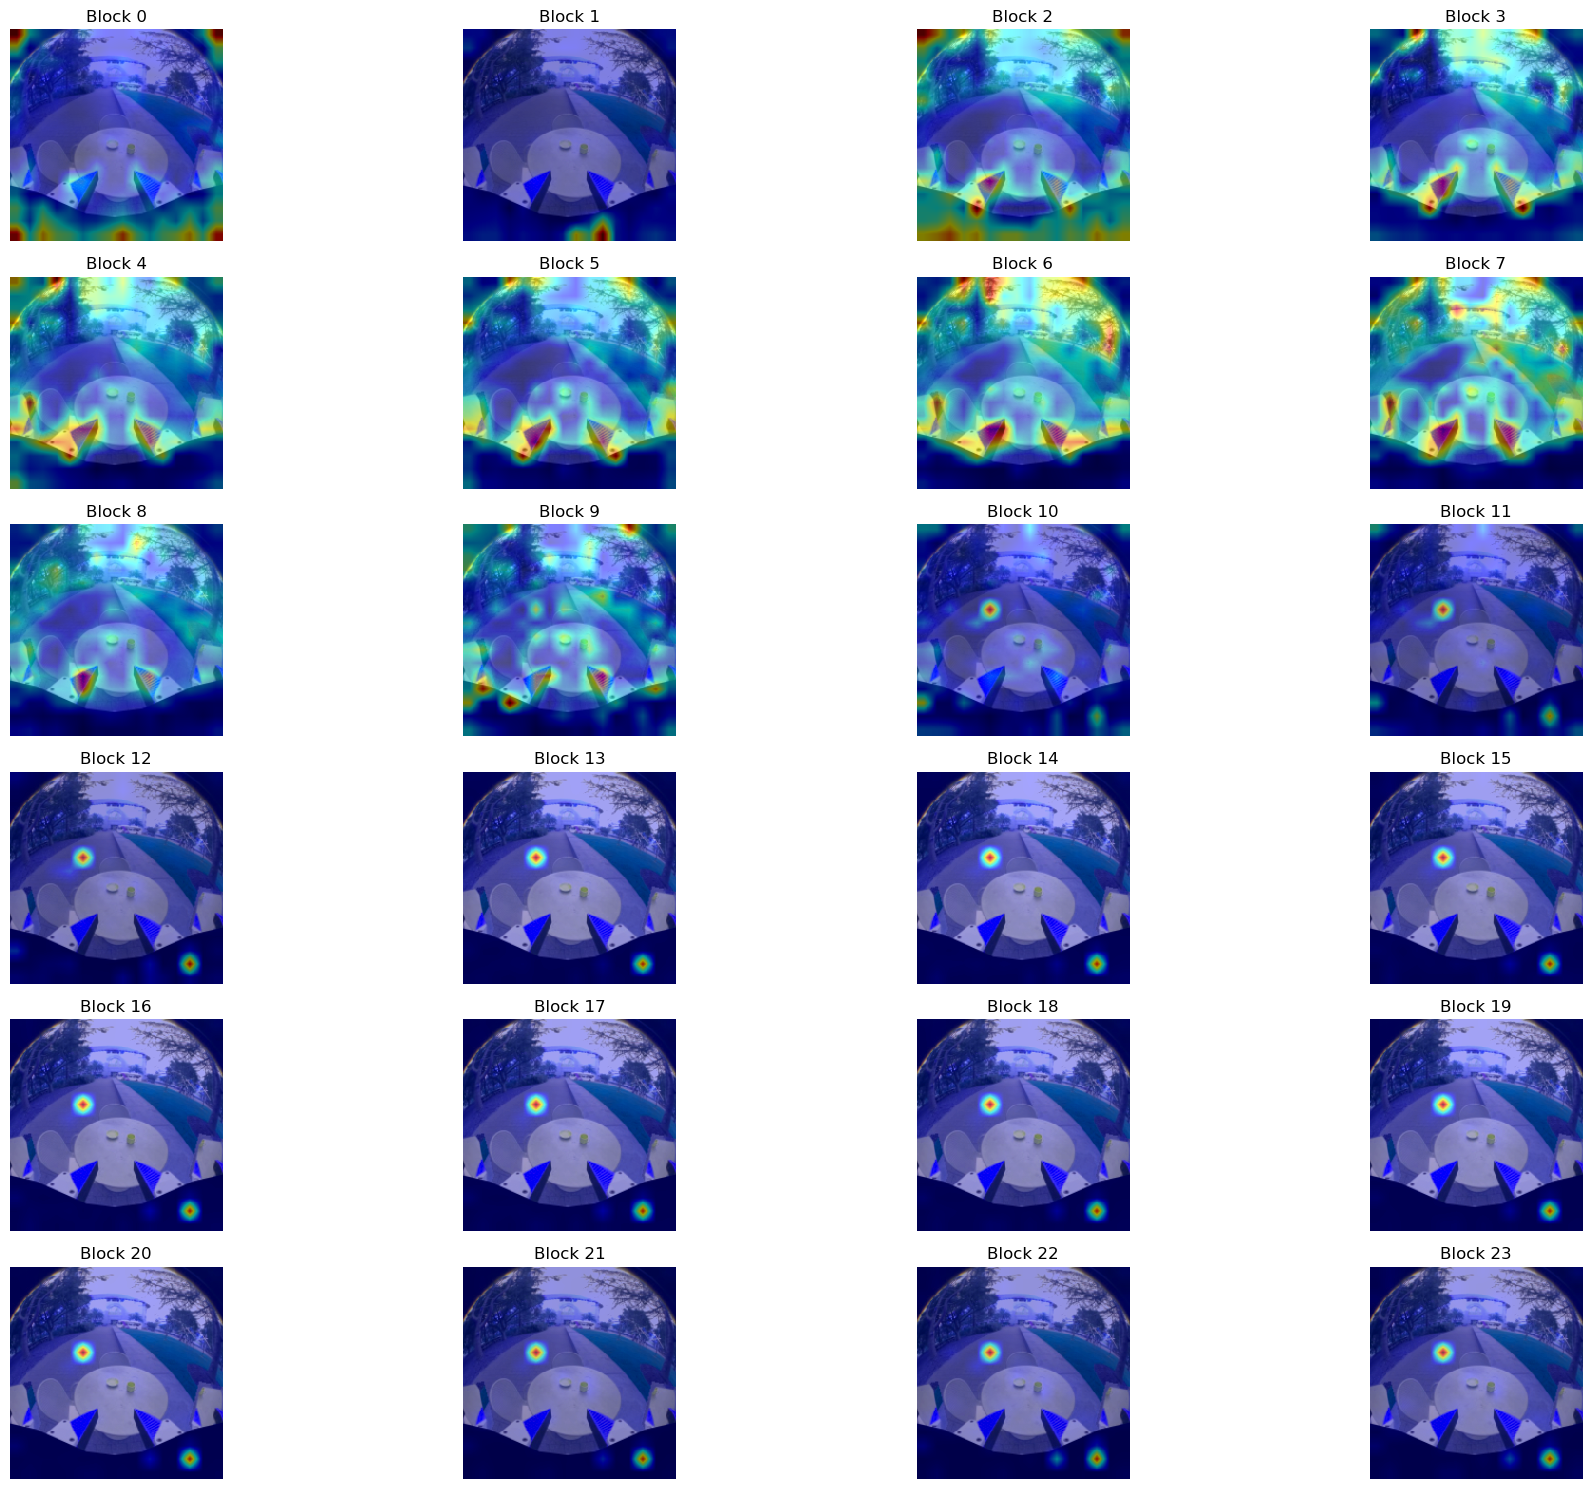

In [404]:
# Function to plot all attention heatmaps
def plot_all_attention_heatmaps(vit, img_processed, img):
    fig, axs = plt.subplots(6, 4, figsize=(20, 15))
    axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

    for block_index in range(0, 24):
        R = get_heatmap_raw_attention_block(vit, block_index)
        
        # Create heatmap from mask on image
        def show_cam_on_image(img, mask):
            heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
            heatmap = np.float32(heatmap) / 255
            cam = heatmap + np.float32(img)
            cam = cam / np.max(cam)
            return cam

        dim = int(R.shape[-1] ** 0.5)
        image_relevance = R.reshape(1, 1, dim, dim)
        image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
        image_relevance = image_relevance.reshape(224, 224).numpy()
        image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
        image = img_processed[0].permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())
        vis = show_cam_on_image(image, image_relevance)
        vis = np.uint8(255 * vis)
        vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

        axs[block_index].imshow(vis)
        axs[block_index].axis('off')
        axs[block_index].set_title(f'Block {block_index}')

    plt.tight_layout()
    plt.show()

# Call the function to plot all heatmaps
plot_all_attention_heatmaps(vit, img_processed, img)

Note: this is also not super informative...

# Averaging Attention
(Pretty sure this is some form of attention rollout?)

In [395]:
# Initializing hook on the first layer

def hook_fn_factory(qkv_vectors):
    def hook_fn(_module, model_in, model_out):
        qkv_vectors.append(model_out)
    return hook_fn

# TODO: complete when figured out...
def get_heatmap_raw_attention_average(vit):
    vit.zero_grad()
    qkv_vectors = [] # Including list for easy pointer access... really will only be size 1
    hook_fn = hook_fn_factory(qkv_vectors)
    hooks = []

    # Setting the hooks
    for block in vit.blocks:
        block_qkv = block.attn.qkv
        hooks.append(block_qkv.register_forward_hook(hook_fn))

    # Running the forward pass
    vit.forward(img_processed)
    for hook in hooks:
        hook.remove()


    A = torch.zeros(qkv_vectors[0].shape[0], qkv_vectors[0].shape[-2], qkv_vectors[0].shape[-2])
    # Getting the attention map
    for qkv_vector in qkv_vectors:
        A = A + get_attention_map(qkv_vector).mean(dim=1)

    # Cleaning up the attention map into a heatmap...
    R = A[:, 0, 1:].detach()
    
    return R

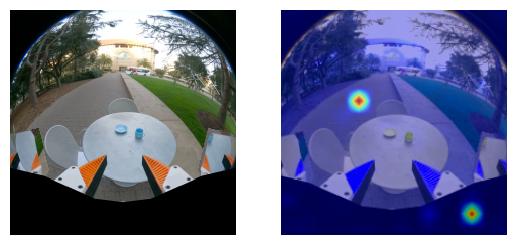

In [396]:
R = get_heatmap_raw_attention_average(vit)
show_image_relevance(R, img_processed, img)

# Transformer-MM-Explainability

Going to use the simple self-attention based way of propagating the gradients...

In [ ]:
# Initializing hook on the last layer

def hook_fn_factory(qkv_vectors):
    def hook_fn(_module, model_in, model_out):
        qkv_vectors.append(model_out)
    return hook_fn

def get_attention_map(kqv):
    assert kqv.shape[-1] == 3072 # Specific assertion for this model...

    q = kqv[:, :, :1024]
    k = kqv[:, :, 1024:2048]

    attn_map = torch.softmax(q @ k.transpose(-2, -1) / math.sqrt(q.shape[-1]), -1)
    return attn_map

# TODO: complete when figured out...
def get_heatmap_raw_attention_first(vit, img):
    vit.zero_grad()
    qkv_vectors = [] # Including list for easy pointer access... really will only be size 1

    # Setting the hooks
    hook_fn = hook_fn_factory(qkv_vectors)
    last_qkv = vit.blocks[0].attn.qkv
    hook = last_qkv.register_forward_hook(hook_fn)

    # Running the forward pass
    vit.forward(img_processed)
    hook.remove()

    # Getting the attention map
    A = get_attention_map(qkv_vectors[0])

    # Cleaning up the attention map into a heatmap...
    R = A[:, 0, 1:].detach()
    
    return R

In [332]:
obs_encoder.model_name

'vit_large_patch14_clip_224.openai'

# Attention Rollout

At least done in the way that Chefer et al. 2021 describes it...

# Experiments... 
(review...)

In [108]:
attention_probs = []
def hook_fn(_module, _in, out):
    attention_probs.append(out.detach())


In [109]:
def attention_heatmap(model, image, device, attention_probs):
    # Forward pass through the model
    _ = model(image.to(device))  # Assume batch size = 1
    
    num_tokens = attn_blocks[0].shape[-1]  # Adjusted to access the correct shape
    batch_size = image.shape[0]

    # Start with an identity matrix for relevance propagation
    R = torch.eye(num_tokens, num_tokens).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)

    for blk in attention_probs:
        # Replace 'attn_probs' with the correct attribute or method
        # attn = blk.attn_probs.detach() if hasattr(blk, 'attn_probs') else blk.some_other_method()
        # attn = attn.mean(dim=1)  # Average across heads
        R = torch.bmm(attn, R)

    # The relevance of each patch relative to the CLS token
    heatmap = R[:, 0, 1:]  # Exclude the CLS token
    return heatmap

In [125]:
# NOTE: only run once... creates hooks on attention blocks
hooks = []
for block in vit.blocks:
    attention = block.attn.attn_drop
    hooks.append(attention.register_forward_hook(hook_fn))

In [126]:
# Running forward
attention_probs = []
vit.zero_grad()
features = vit(img_processed)

In [127]:
len(attention_probs) # should be 24

0

In [115]:
attention_probs[12].shape

torch.Size([1, 257, 1024])

In [77]:
# Initializing relevancy matrix
num_tokens = attention_probs[0].shape[-2]
batch_size = attention_probs[0].shape[0]

R = torch.eye(num_tokens, num_tokens)
R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)

In [ ]:
# Updaing the relevancy matrix

for blk in attention_probs:
    # Replace 'attn_probs' with the correct attribute or method
    # attn = blk.attn_probs.detach() if hasattr(blk, 'attn_probs') else blk.some_other_method()
    # attn = attn.mean(dim=1)  # Average across heads
    R = torch.bmm(attn, R)

In [97]:
attention_probs = []

In [131]:
for hook in hooks:
    hook.remove()